In [1]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict,List, Dict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END
from langchain_core.runnables.config import RunnableConfig


In [2]:
class AgentState(TypedDict):
    question:str
    sql_query:str
    fetched_rows:list
    final_answer:str
    sql_error:str
    attempts:int
    relevance:str
    token_limit_error:bool



In [4]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
db_path = r'database\database.db'
engine = create_engine(f'sqlite:///{db_path}')

def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

In [ ]:
from langchain_openai import AzureChatOpenAI
os.environ["AZURE_OPENAI_ENDPOINT"] = ""

llm = AzureChatOpenAI(
    model='gpt-4o-mini',
    azure_deployment="",  # or your deployment
    api_version="", # or your api version
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [6]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState):
    question = state["question"]
    print
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

        Schema:
        {schema}

        Respond with only "relevant" or "not_relevant".
        """.format(schema=schema)

    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", f"Question: {question}"),
        ]
    )
  
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

In [7]:

class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState):
    question = state["question"]
    # current_user = state["current_user"]
    schema = get_database_schema(engine)
    #print(f"Converting question to SQL for user '{current_user}': {question}")
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

    {schema}

    - Use only base_data table to answer the question.
    Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.

    For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
    """.format(schema=schema)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    # llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state

In [8]:
import traceback
def execute_sql_query(state:AgentState):
    """ This function executes a SQL query and returns the result. """
    print("Executing SQL query...")
    query = state["sql_query"]
    with engine.connect() as conn:
        try:
            result = conn.execute(text(query))
            state["fetched_rows"] = result.fetchall()
            print('--------------Fetched rows:--------------------')
            print(state["fetched_rows"])
            print(len(state["fetched_rows"]))
            return state
        except Exception as e:
            print("*********")
            state["sql_error"] = str(e)
            print('&&&&&&&&&&&&&&&',state["sql_error"])
            return state
        

In [10]:

def regenerate_sql_query(state:AgentState):
    original_sql_query = state["sql_query"]
    error_msg = state["sql_error"]
    user_question = state["question"]
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print(user_question)
    system = f"""
    You are an expert SQL query generator.
    You are given the original sql query that caused the error,you are also provided with error message, re generate a new sql query that fixes the error.

    Strictly don't write the same sql query again,it was given to you since there is an error.Think of any other way you can write query to achieve the result for the given user question.

    
    -If the user asks to get all records from a table, you should use the SELECT * statement.
    
    Please do double check that regenerated query doesn't go wrong.
    Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.

    For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
     """
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", f"""
                        user question: {user_question}
                        original_sql_query: {original_sql_query}
                        error_message: {error_msg}
                        """),
        ]
    )
    # llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"user_question":user_question,"original_sql_query": original_sql_query,"error_message":error_msg})
    state["sql_query"] = result.sql_query
    state["sql_error"] = ""
    state["attempts"] += 1
    print(f"Re-Generated SQL query: {state['sql_query']}")
    return state
    
    

In [11]:
#regenerate_sql_query({"sql_query":"SELECT *FROM base_data WHERE 'Region'='AZP","sql_error":"syntax error near column Region","attempts":0})

In [12]:
def generate_human_readable_answer(state: AgentState):
    try:
        sql_query = state["sql_query"]
        user_question = state["question"]
        result = state["fetched_rows"]
        # current_user = state["current_user"]
        #query_rows = state.get("query_rows", [])
        sql_error = state.get("sql_error", False)
        print("Generating a human-readable answer.")
        system = """You are provided with the sql_query and results obtained by running the query on database.
        Your task is to generate a human-readable answer to the user's question.    
        """

        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""User's question: {user_question}
                        SQL Query : {sql_query}
                        Data obtained : {result}
                    """
                ),
            ]
        )
        
        human_response = generate_prompt | llm 
        answer = human_response.invoke({})
        
        state["final_answer"] = answer.content
        chat_history.append({"question": user_question, "answer": answer.content})
        print("Generated human-readable answer.")
        return state
    except Exception as e:
        print(f"Error generating human-readable answer: {e}")
        state["token_limit_error"] = True
        return state

In [14]:
def generic_response(state:AgentState):
    question = state["question"]
    schema = get_database_schema(engine)
    system = """You are an database agent ,which helps to answer question based on the the database.
    You are also provided with the schema of the database.
    schema:
    {schema}

    If the user greets you, respond with a friendly greeting and tell them what you can do.
    """.format(schema=schema)

    generate_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"""User's question: {question}"""
            ),
        ]
    )
    
    human_response = generate_prompt | llm 
    answer = human_response.invoke({})
    
    state["final_answer"] = answer.content
    chat_history.append({"question": question, "answer": answer.content})
    return state


In [15]:
#generic_response({"question":"Hello"})


In [16]:
def handle_large_dataset(state:AgentState):
    user_question = state["question"]
    fetched_rows = state["fetched_rows"]
    print("TOOL : Handling large dataset")
    prompt = """
                You are an expert data analyst who is analyzing a large dataset.You are given subset of data as of now.
                Actually user asked the question on the entire dataset,but since it's exceeding the token limit,I am breaking down subset of data and giving you to analyze.
                Again the answer provided by you for all the subsets will be combined to form the final answer.
                So also keep track of some records if they are required in the final answer.

                User question: {user_question}
                Subset of data: {fetched_rows}
                """

    response_of_subsets = ""
    for i in range(0, len(fetched_rows), 1000):
        subset = fetched_rows[i:i+1000]
        system_prompt = prompt.format(user_question=user_question, fetched_rows=subset)
       
        subset_response = llm.invoke(system_prompt).content
        
        response_of_subsets += f"Response of {i+1} subset"+"\n" +subset_response+"\n"
        print("TOOL : Response of subset "+str(i+1)+" : "+subset_response)

    final_response = llm.invoke(f"""Answer the user question based on the response of subsets.
                        User question :{user_question}
                        response_of_subsets: {response_of_subsets}
                    """).content
    print("TOOL : Final response : "+final_response)
    state["final_answer"] = final_response
    return state

In [17]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_nl_to_sql"
    else:
        return "generic_response"

def end_max_iterations(state: AgentState):
    state["final_answer"] = "Sorry , couldn't find what you are looking for. Please try to rephrase the query or ask an other query"
    print("Maximum attempts reached. Ending the workflow.")
    return state

def check_attempts_router(state: AgentState):
    if state["attempts"] < 4:
        return "execute_sql_query"
    else:
        return "end_max_iterations"
    
def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        print('***********')
        return "generate_human_readable_answer"
    else:
        return "regenerate_sql_query"
    
def token_limit_router(state: AgentState):
    if state["token_limit_error"]:
        return "handle_large_dataset"
    else:
        return "end"

In [18]:
workflow = StateGraph(AgentState)

workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_nl_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("regenerate_sql_query", regenerate_sql_query)
workflow.add_node("generate_human_readable_answer",generate_human_readable_answer)
workflow.add_node("handle_large_dataset", handle_large_dataset)
workflow.add_node("generic_response", generic_response)
workflow.add_node("end_max_iterations", end_max_iterations)


workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_nl_to_sql": "convert_nl_to_sql",
        "generic_response": "generic_response",
    },
)

workflow.add_edge("convert_nl_to_sql", "execute_sql_query")
workflow.add_conditional_edges(
    "execute_sql_query",
     execute_sql_router,
     {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_sql_query": "regenerate_sql_query",
     },
)

workflow.add_conditional_edges(
    "regenerate_sql_query",
    check_attempts_router,
    {
        "execute_sql_query": "execute_sql_query",
        "end_max_iterations": "end_max_iterations",
    },
)

workflow.add_conditional_edges(
    "generate_human_readable_answer",
    token_limit_router,
    {
        "handle_large_dataset": "handle_large_dataset",
        "end":END
    }
)

workflow.set_entry_point("check_relevance")
workflow.add_edge("generate_human_readable_answer", END)

app = workflow.compile()

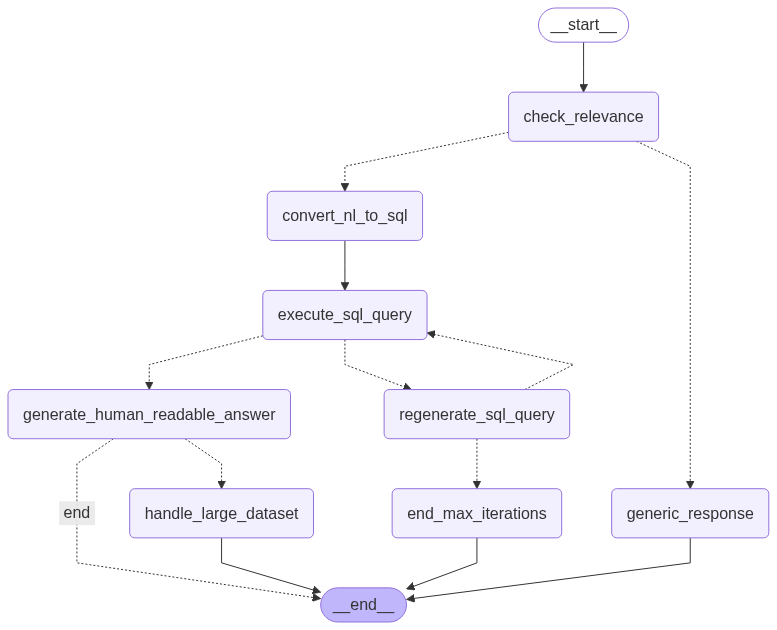

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
user_question_1 = "can you summarize the information available in the database?"
result_1 = app.invoke({"question": user_question_1, "attempts": 0})
print(result_1)